#### When combining NDEs, weigh each NDE using CV

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import pickle
import corner
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

import torch
from sklearn.model_selection import train_test_split

os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import SuperSpeculator
import popsed
popsed.set_matplotlib(style='JL', usetex=False, dpi=80)
from popsed import prior

In [3]:
## Load SuperSpeculator
wave = np.load('./train_sed_NMF/nmf_seds/fsps.wavelength.npy')
speculator = SuperSpeculator(
    speculators_dir=[f'./train_sed_NMF/best_emu/speculator_best_recon_model_NMF.emu_{i_bin}.pkl' for i_bin in range(0, 5)], 
    str_wbin=[
              '.w1000_2000',
              '.w2000_3600', 
              '.w3600_5500', 
              '.w5500_7410', 
              '.w7410_60000'],
    wavelength=wave, 
    params_name=['kappa1_sfh', 'kappa2_sfh', 'kappa3_sfh', 
                 'fburst', 'tburst', 'logzsol', 'dust1', 'dust2', 
                 'dust_index', 'redshift', 'logm'])

noise = 'nsa'
noise_model_dir = './noise_model/nsa_noise_model_mag.npy'
filters = ['sdss_{0}0'.format(b) for b in 'ugriz']

In [4]:
def gen_truth(N_samples=5000):
    ncomp = 4
    priors = prior.load_priors([
            # Log stellar mass, in M_sun
            prior.GaussianPrior(10.5, 0.4, label='logm'),
            # flat dirichilet priors for SFH
            prior.TruncatedNormalPrior(0, 1, 0.5, 0.1), 
            prior.TruncatedNormalPrior(0, 1, 0.5, 0.1), 
            prior.TruncatedNormalPrior(0, 1, 0.5, 0.1), 
    #         prior.FlatDirichletPrior(ncomp, label='beta'),
            # uniform priors on the mass fraction of burst
            prior.TruncatedNormalPrior(0, 0.6, 0.2, 0.1, label='fburst'),
            # uniform priors on star-burst lookback time
            prior.TruncatedNormalPrior(1e-2, 13.27, 5, 1.5, label='tburst'),
            # uniform priors on log-metallicity, absolute Z
            prior.TruncatedNormalPrior(-2.6, 0.3, -1, 0.3, label='logzsol'),
            # uniform priors on dust1
            prior.TruncatedNormalPrior(0., 3., 0.6, 0.3, label='dust1'),
            # uniform priors on dust2
            prior.TruncatedNormalPrior(0., 3., 0.6, 0.3, label='dust2'),
            # uniform priors on dust_index
            prior.TruncatedNormalPrior(-3., 1., -1, 0.3, label='dust_index'),
            # uniformly sample redshift
            prior.TruncatedNormalPrior(0., 1.5, 0.08, 0.05, label='redshift')
        ])
    
    _thetas_unt = np.array([priors.sample() for i in range(N_samples)])
    _thetas = np.hstack([_thetas_unt[:, 0:1], 
               prior.FlatDirichletPrior(4).transform(_thetas_unt[:, 1:4]), 
               _thetas_unt[:, 4:]])
    
    return _thetas, _thetas_unt

In [5]:
_thetas, _thetas_unt = gen_truth(N_samples=7000)

Y_truth = np.hstack([_thetas_unt[:, 1:], # params taken by emulator, including redshift (for t_age)
                     _thetas_unt[:, 0:1], # stellar mass
                    ])
Y_truth = torch.Tensor(Y_truth).to('cuda')

X_data = speculator._predict_mag_with_mass_redshift(Y_truth, filterset=filters,
    noise=noise, 
    noise_model_dir=noise_model_dir)

flag = ~(torch.isnan(X_data).any(dim=1) | torch.isinf(X_data).any(dim=1))
flags = [((Y_truth[:, i] < speculator.bounds[i, 1]) & (Y_truth[:, i] > speculator.bounds[i, 0])).cpu().numpy()
 for i in range(len(speculator.bounds))]
flag = flag.cpu().numpy() & np.array(flags).all(axis=0)

X_data = X_data[flag].detach()
Y_truth = Y_truth[flag]

In [6]:
nde_dir = './NDE/NMF/nde_theta_NMF_sdss_noise/'
filelist = os.listdir(nde_dir)
# filelist = ['nde_theta_best_loss_nsf_4.pkl',
#             'nde_theta_best_loss_nsf_11.pkl',]

In [7]:
# This is slow
NDE_list = []
for file in filelist:
    try:
        NDE = pickle.load(open(os.path.join(nde_dir, file), 'rb'))
        del NDE.X
        del NDE.X_vali
        NDE_list.append(NDE)
        if NDE.best_model.vali_loss_history[-1] > 0.15:
            print('Poor vali loss for', file)
#             print('Remove', file)
    except Exception as e:
        print(file, e)
        continue

Poor vali loss for nde_theta_best_loss_nsf_1.pkl
Poor vali loss for nde_theta_best_loss_nsf_12.pkl
Poor vali loss for nde_theta_best_loss_nsf_2.pkl
Poor vali loss for nde_theta_best_loss_nsf_16.pkl
Poor vali loss for nde_theta_best_loss_nsf_8.pkl
Poor vali loss for nde_theta_best_loss_nsf_3.pkl


In [68]:
### score for each model is vali_loss

In [8]:
vali_loss = np.array([NDE.best_model.vali_loss_history[-1] for NDE in NDE_list])
vali_loss

array([0.09430653, 0.0761412 , 0.10338245, 0.16759819, 0.07242323,
       0.07953507, 0.07576729, 0.08915662, 0.08315612, 0.36416417,
       0.05279129, 0.07524161, 0.10042202, 0.47305626, 0.07003441,
       0.07275695, 0.19207932, 0.17344101, 0.05385247, 0.31420654])

In [9]:
score = np.min(vali_loss) / vali_loss
score

array([0.55978401, 0.69333404, 0.51064072, 0.31498721, 0.72892749,
       0.6637485 , 0.6967556 , 0.59211852, 0.63484544, 0.14496562,
       1.        , 0.70162356, 0.52569434, 0.11159621, 0.75379064,
       0.72558407, 0.27484107, 0.30437604, 0.98029457, 0.1680146 ])

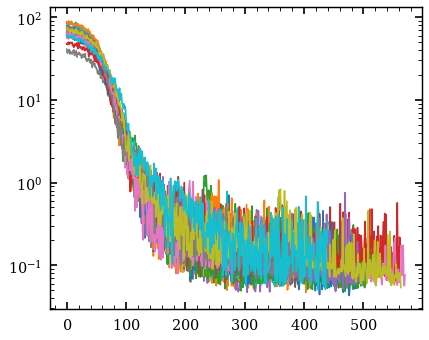

In [10]:
[plt.plot(NDE.vali_loss_history) for NDE in NDE_list]
plt.yscale('log')

In [13]:
n = 1500
samples = torch.vstack([NDE.best_model.sample(int(n * s)) for NDE, s in zip(NDE_list, list(score))])

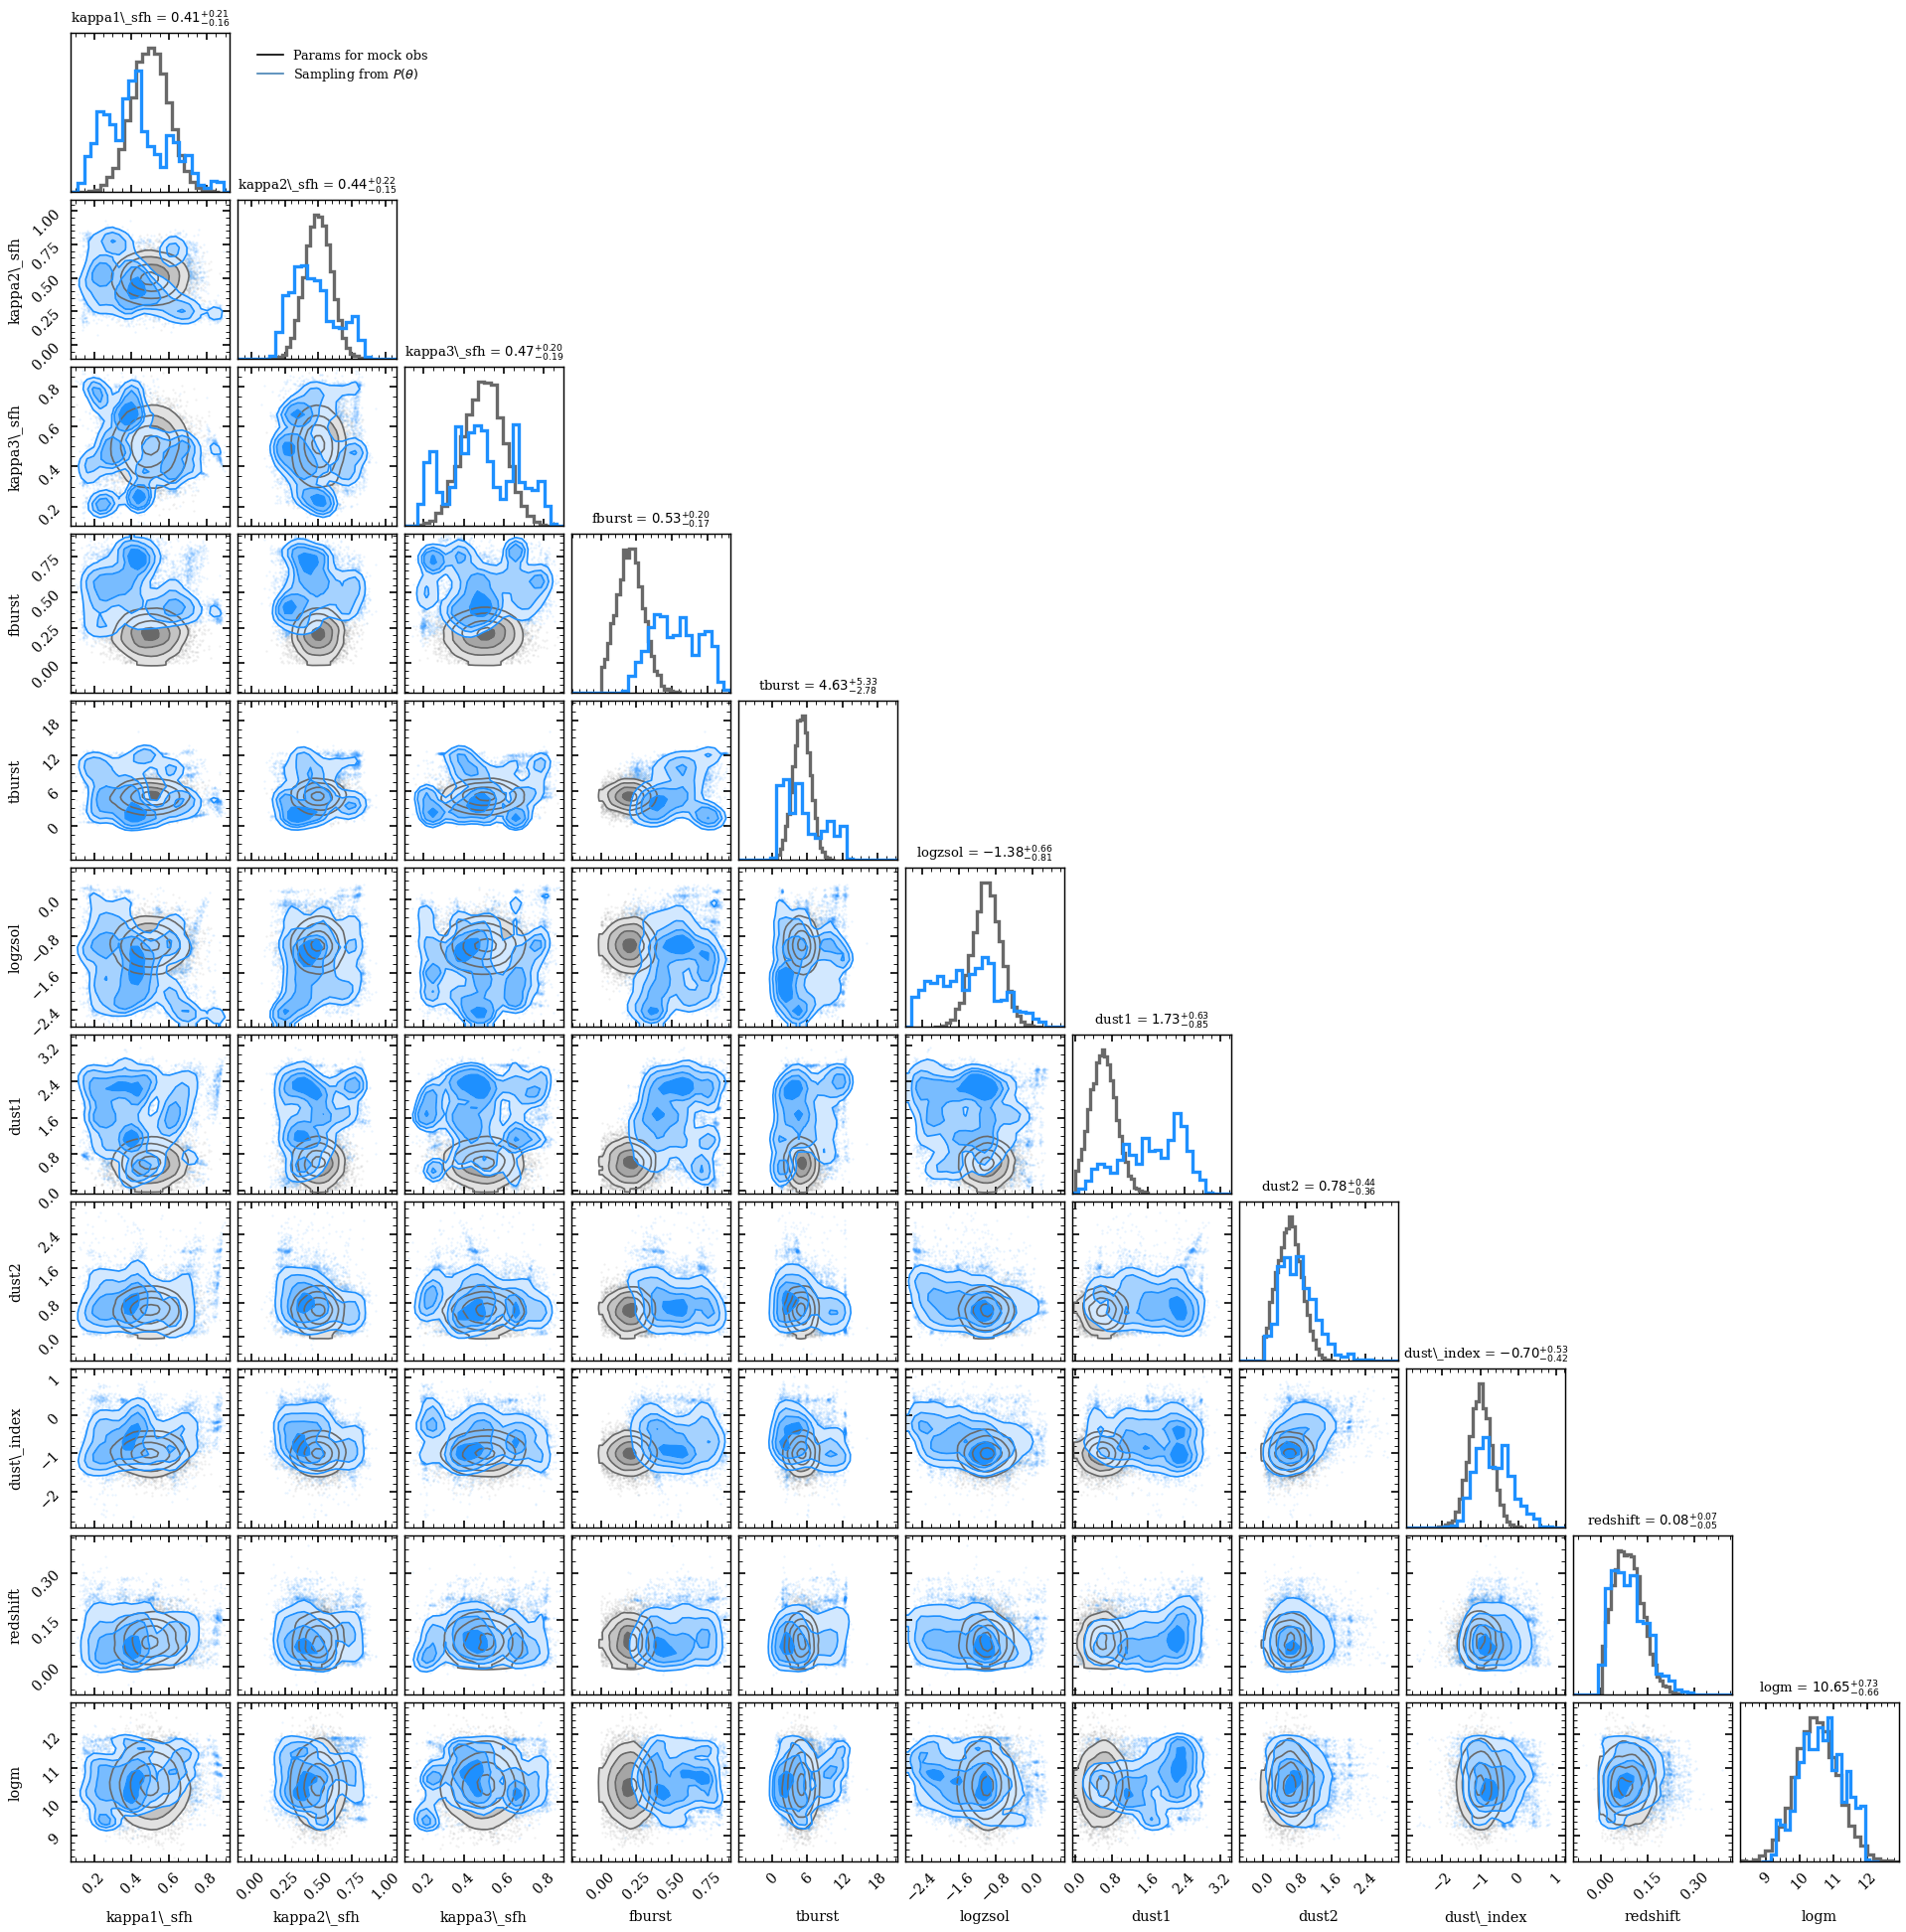

In [14]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Params for mock obs')
b_line = mlines.Line2D([], [], color='steelblue', label=r'Sampling from $P(\theta)$')

labels = [key.replace('_', '\_') for key in speculator.params_name]

figure = corner.corner(Y_truth.cpu().detach().numpy(), 
                       color='dimgray', labels=labels, bins=25,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=1, fill_contours=True,
                       show_titles=True, title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

nf_plot = corner.corner(samples.cpu().detach().numpy(), 
                  fig=figure, labels=labels, bins=25,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=1, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True})

ax = nf_plot.get_axes()[1]
ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

In [15]:
_samples_unt = samples.cpu().detach().numpy()
_samples = np.hstack([_samples_unt[:, -1:], 
               prior.FlatDirichletPrior(4).transform(_samples_unt[:, :3]), 
               _samples_unt[:, 3:-1]])

In [16]:
k_line = mlines.Line2D([], [], color='k', label='Params for mock obs')
b_line = mlines.Line2D([], [], color='steelblue', label=r'Sampling from $P(\theta)$')

_labels = [f'beta{i}_sfh' for i in range(1,5)] + speculator.params_name[3:]
_labels = [key.replace('_', '\_') for key in _labels]


# Distribution of beta coeffs
y_truth_trans = np.hstack([_thetas[:, 1:], # params taken by emulator, including redshift (for t_age)
                           _thetas[:, 0:1], # stellar mass
                    ])

figure = corner.corner(y_truth_trans, 
                       quantiles=[0.16, 0.5, 0.84], 
                       labels=_labels,
                       smooth=0.3,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

y_truth_trans = np.hstack([_samples[:, 1:], # params taken by emulator, including redshift (for t_age)
                           _samples[:, 0:1], # stellar mass
                    ])

nf_plot = corner.corner(y_truth_trans, 
                  fig=figure, labels=_labels, bins=25,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=1, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True})

ax = nf_plot.get_axes()[1]
ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

In [17]:
del _samples, _samples_unt, samples

In [18]:
torch.cuda.empty_cache()

### Show each NDE

In [19]:
_samples_unt = []
_samples = []
for NDE in [NDE_list[i] for i in np.argsort(vali_loss)[:14]]:
    _samp = NDE.best_model.sample(1500).cpu().detach().numpy()
    _samples_unt.append(_samp)
    _samples.append(np.hstack([_samp[:, -1:], 
                   prior.FlatDirichletPrior(4).transform(_samp[:, :3]), 
                   _samp[:, 3:-1]]))
_samples_unt = np.dstack(_samples_unt)
_samples = np.dstack(_samples)

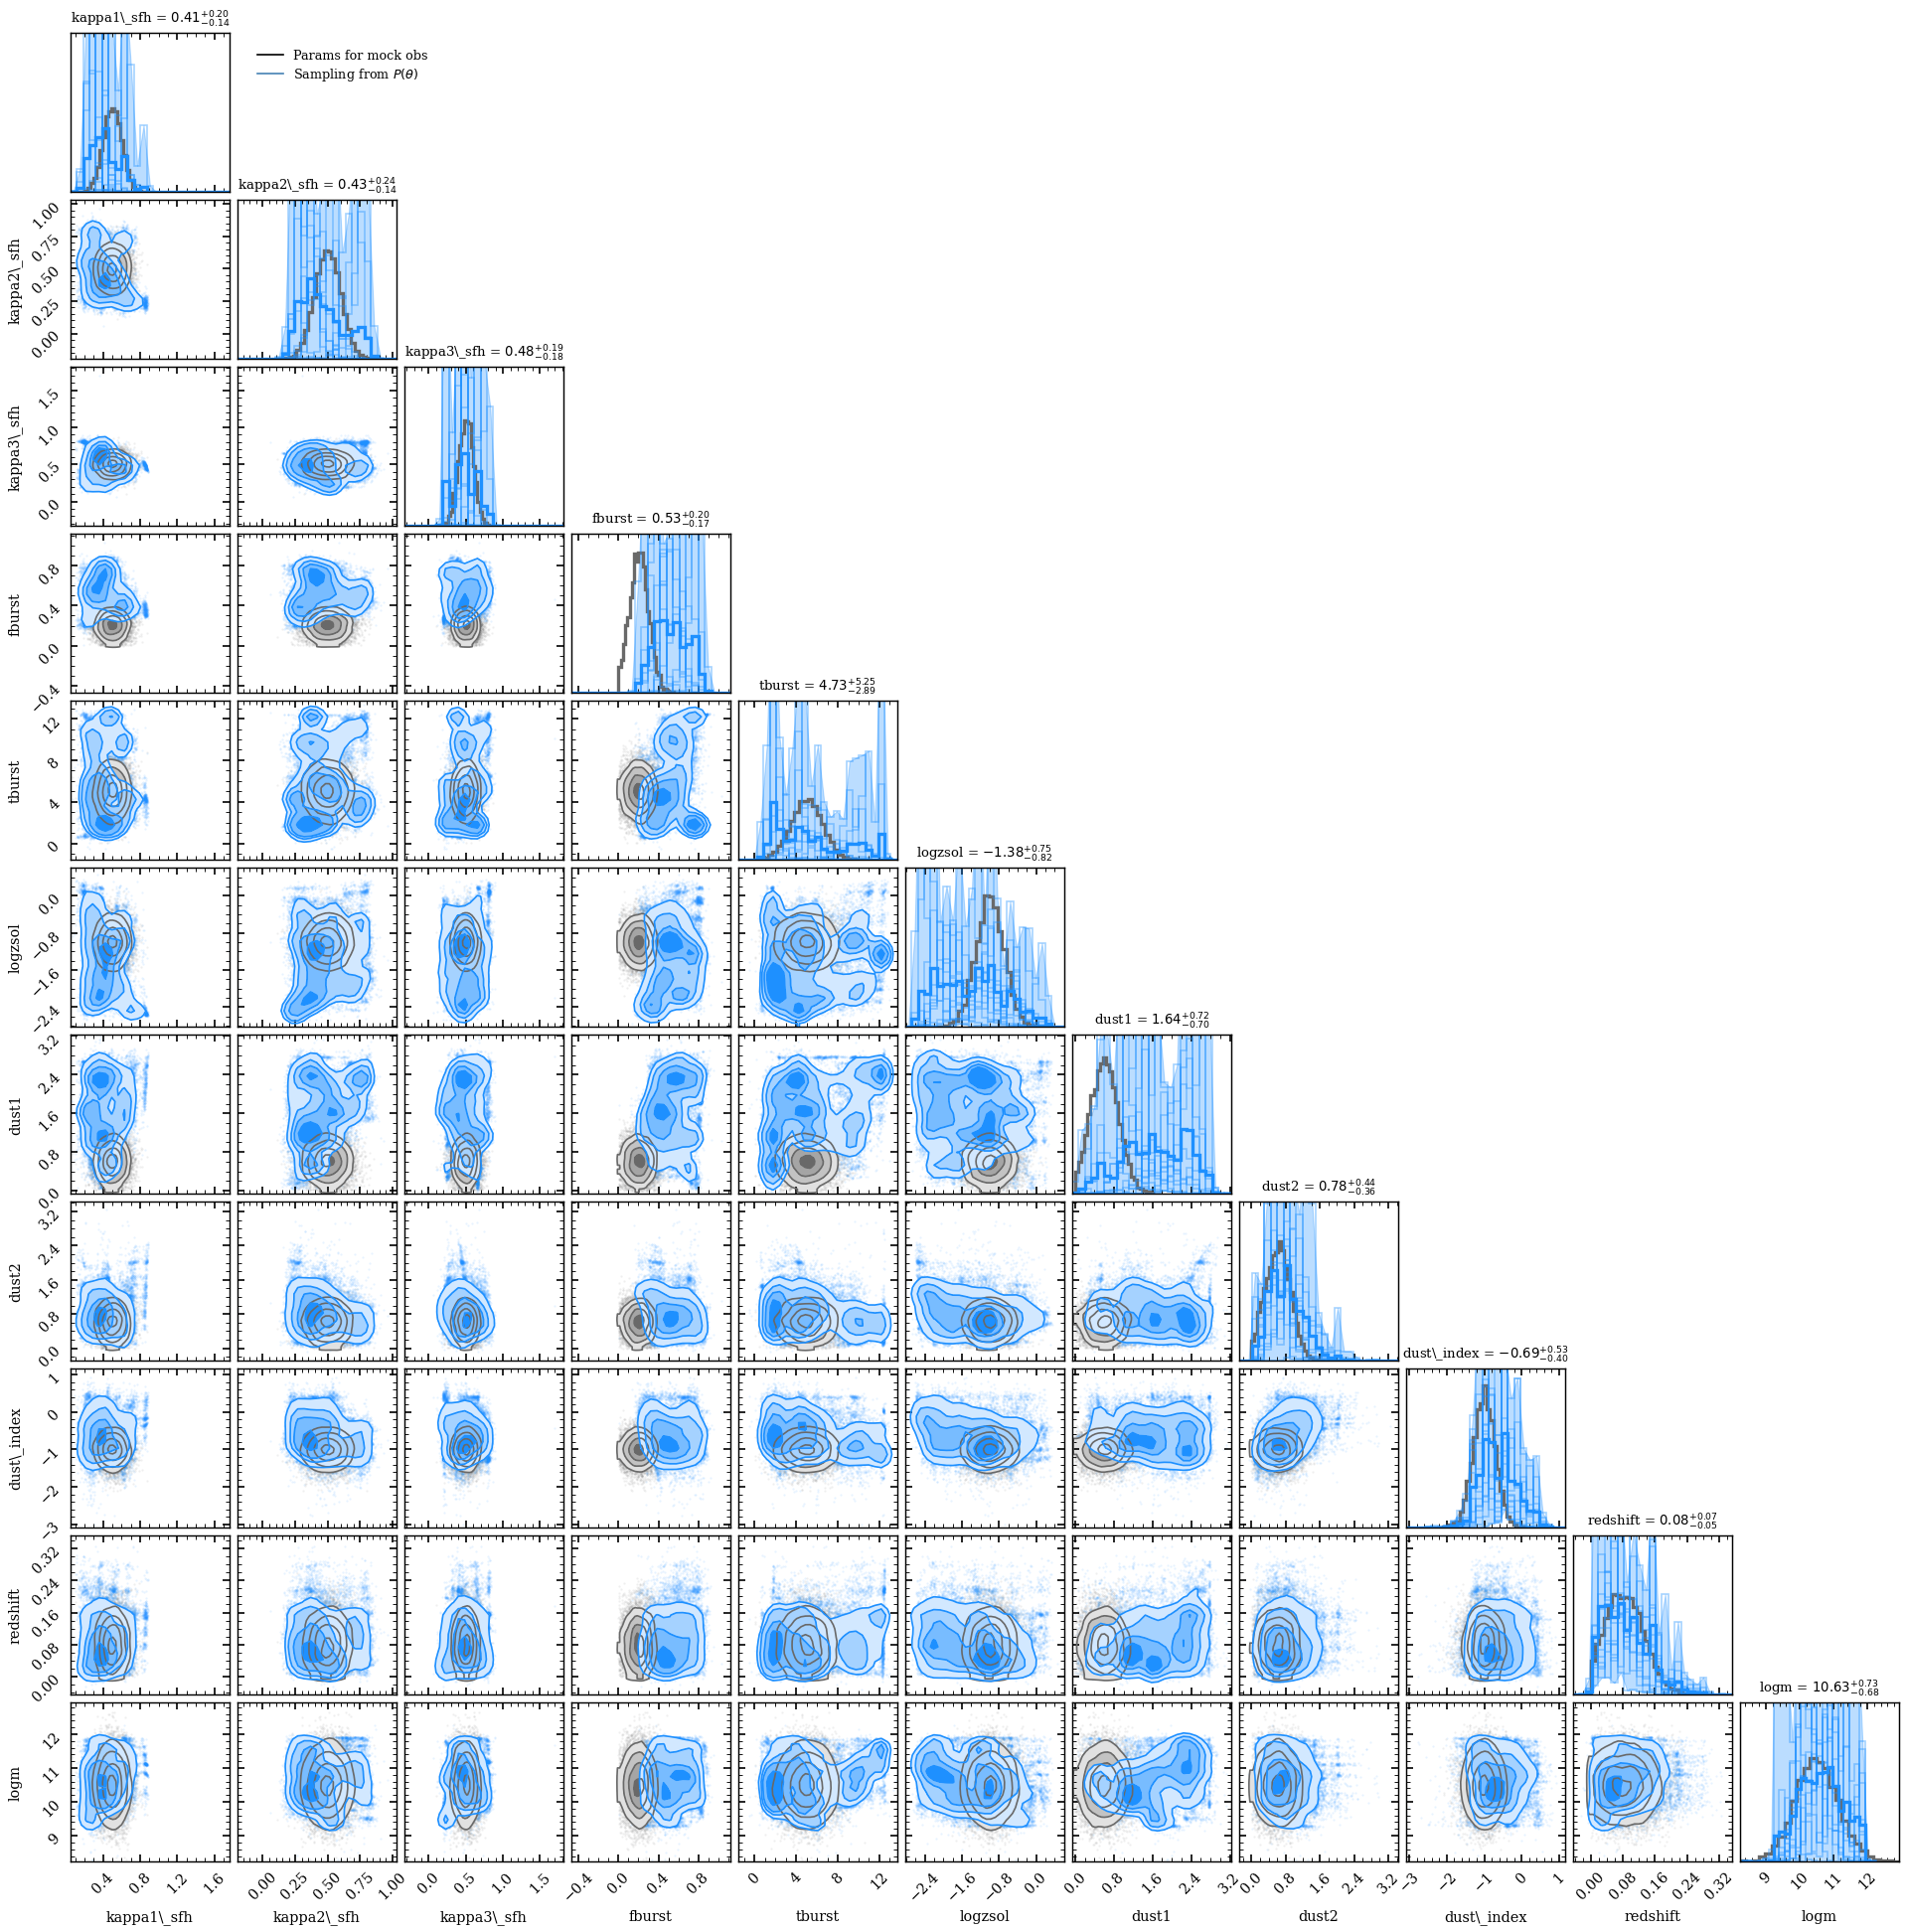

In [20]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Params for mock obs')
b_line = mlines.Line2D([], [], color='steelblue', label=r'Sampling from $P(\theta)$')

labels = [key.replace('_', '\_') for key in speculator.params_name]

figure = corner.corner(Y_truth.cpu().detach().numpy(), 
                       color='dimgray', labels=labels, bins=25,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=1, fill_contours=True,
                       show_titles=True, title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

nf_plot = corner.corner(_samples_unt, 
                  fig=figure, labels=labels, bins=25,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=1, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True})

ax = nf_plot.get_axes()[1]
ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

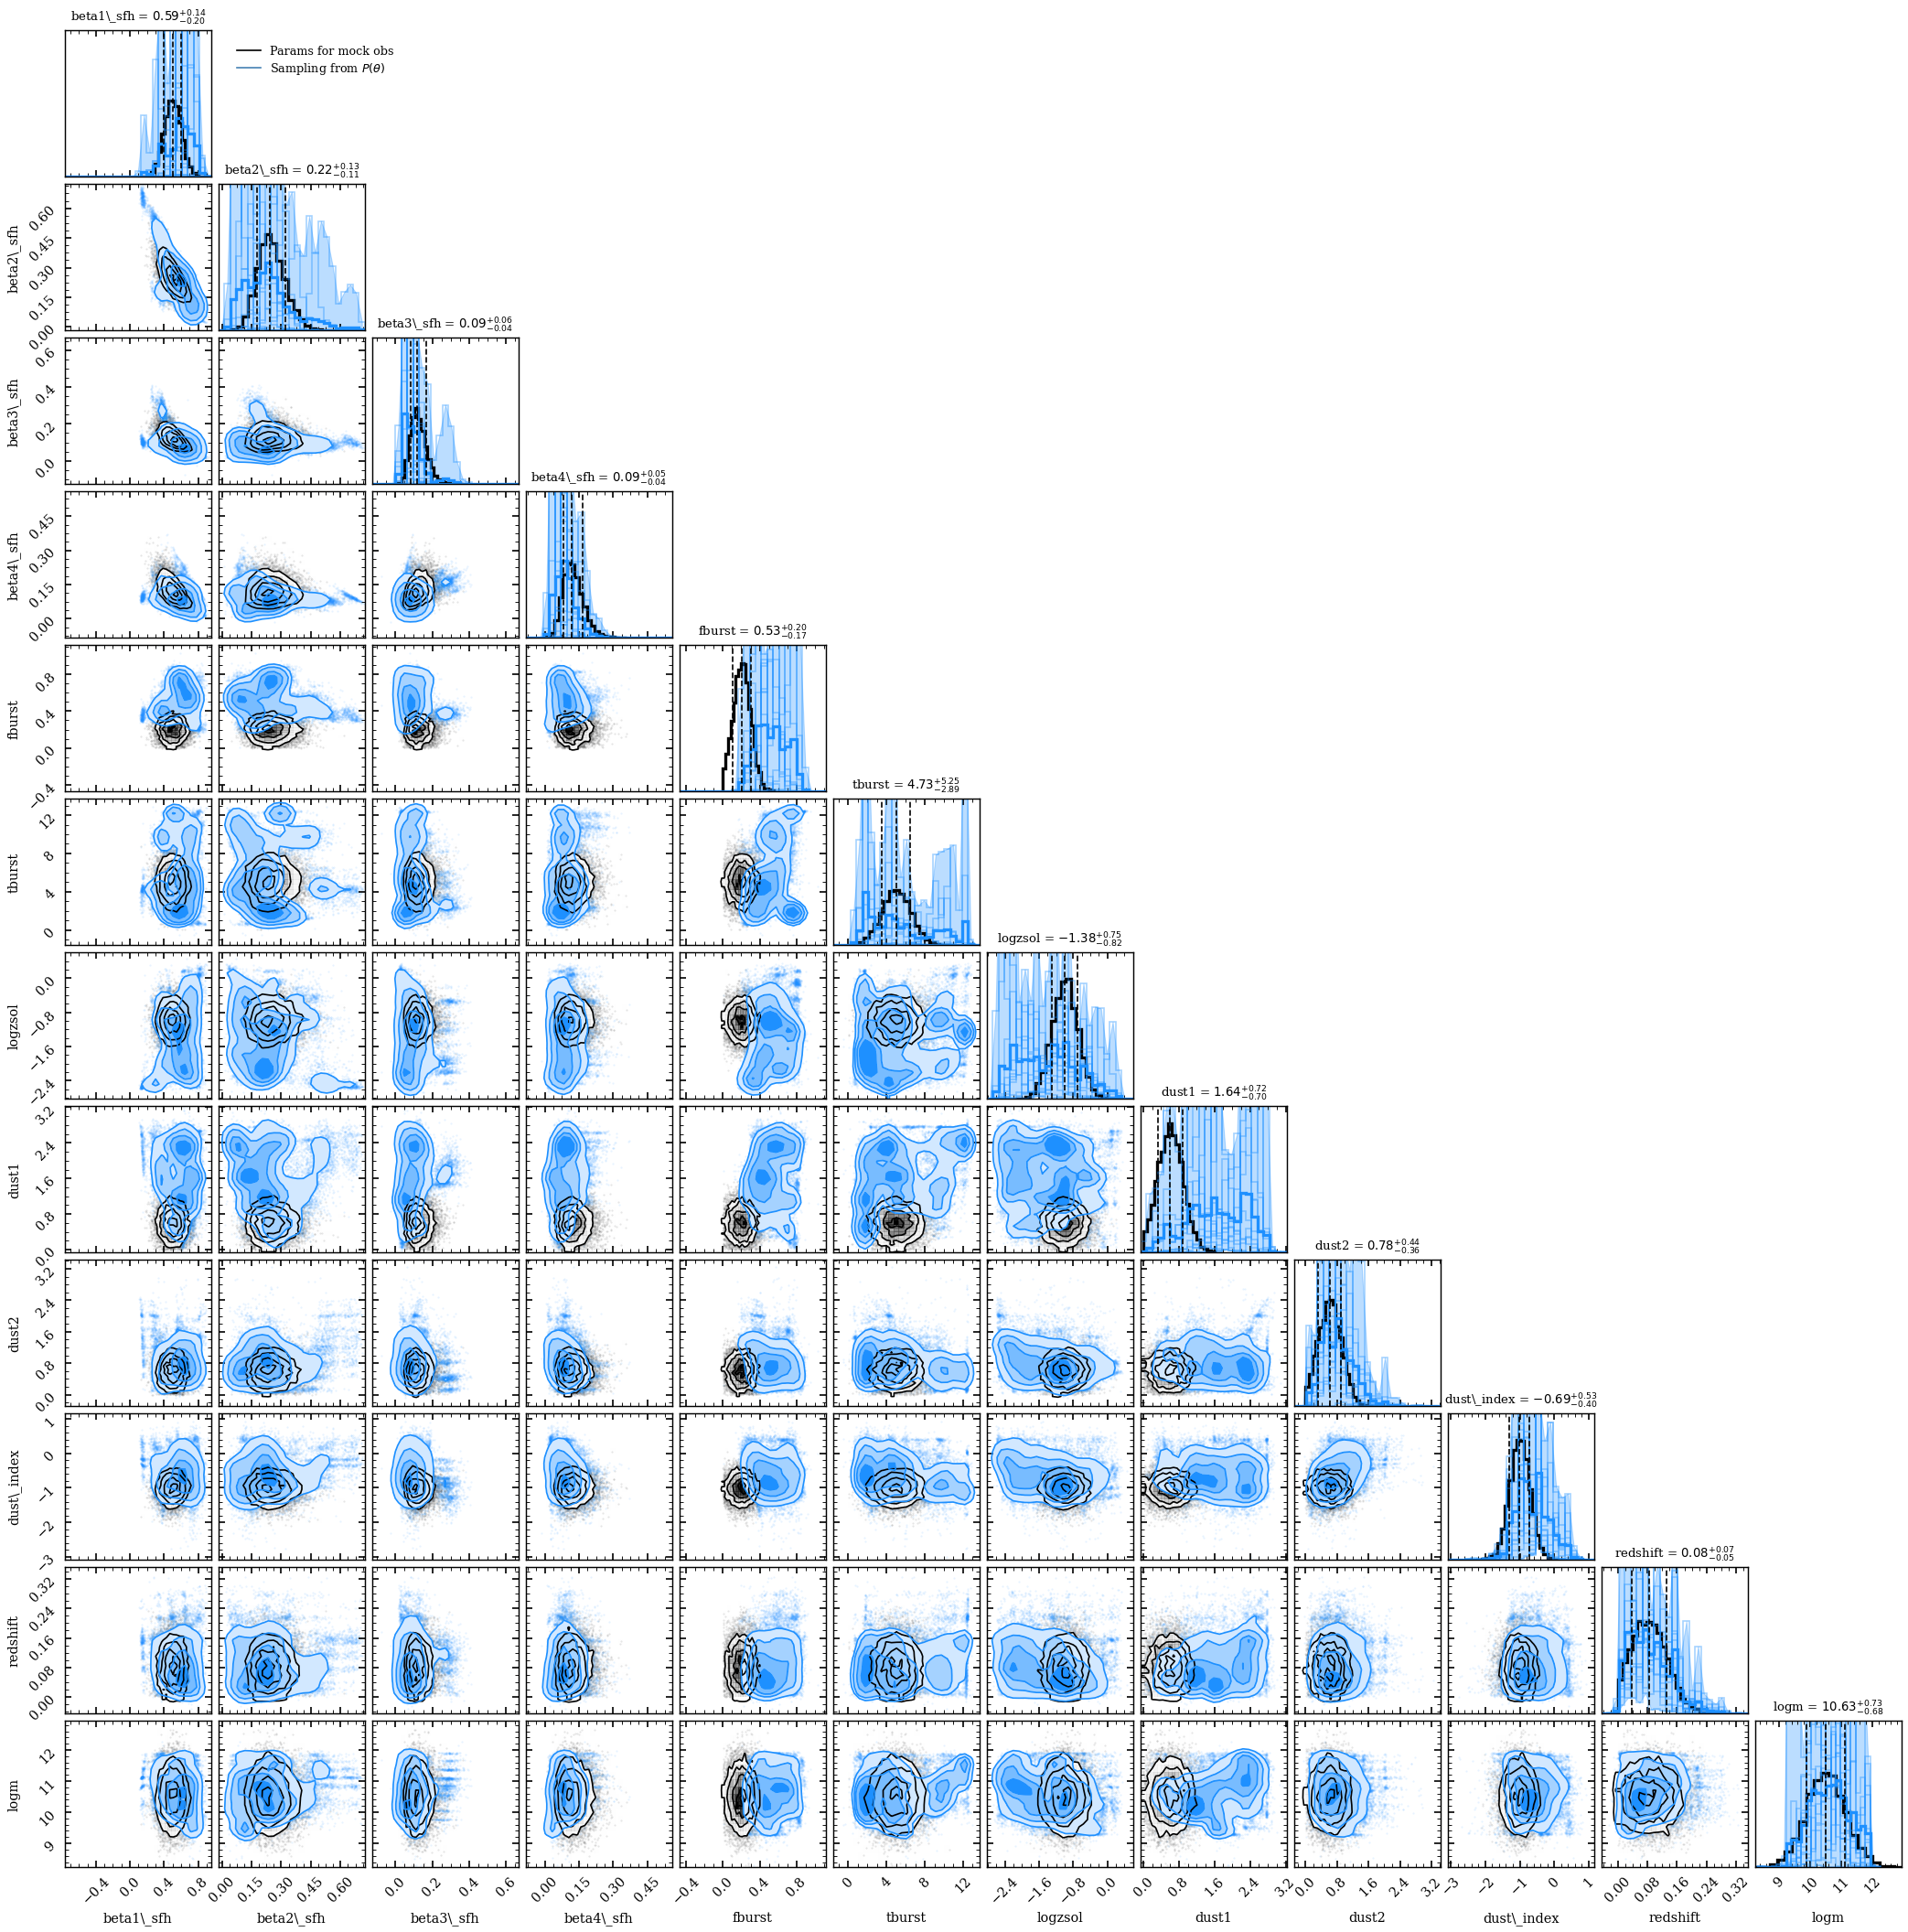

In [21]:
k_line = mlines.Line2D([], [], color='k', label='Params for mock obs')
b_line = mlines.Line2D([], [], color='steelblue', label=r'Sampling from $P(\theta)$')

_labels = [f'beta{i}_sfh' for i in range(1,5)] + speculator.params_name[3:]
_labels = [key.replace('_', '\_') for key in _labels]


# Distribution of beta coeffs
y_truth_trans = np.hstack([_thetas[:, 1:], # params taken by emulator, including redshift (for t_age)
                           _thetas[:, 0:1], # stellar mass
                    ])

figure = corner.corner(y_truth_trans, 
                       quantiles=[0.16, 0.5, 0.84], 
                       labels=_labels,
                       smooth=0.3,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

y_truth_trans = np.hstack([_samples[:, 1:], # params taken by emulator, including redshift (for t_age)
                           _samples[:, 0:1], # stellar mass
                    ])

nf_plot = corner.corner(y_truth_trans, 
                  fig=figure, labels=_labels, bins=25,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=1, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True})

ax = nf_plot.get_axes()[1]
ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

In [23]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Data')
#r_line = mlines.Line2D([], [], color='tomato', label='NDE for the data')
b_line = mlines.Line2D([], [], color='dodgerblue', label=r'$P(\theta)$ sample + forward model')

labels = filters

figure = corner.corner(X_data.cpu().detach().numpy(), 
                       color='k', labels=labels, bins=30,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.4, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

mags = speculator._predict_mag_with_mass_redshift(_samples_unt.swapaxes(0, 1).reshape(11, -1).T,
                                                  filterset=filters,
                                                  noise=noise,
                                                  noise_model_dir=noise_model_dir,
                                                  ).cpu().detach().numpy()
print(np.isnan(mags).any(axis=1).sum(), len(mags))
print('>30', np.any(mags > 30, axis=1).sum())
mags = mags[~(np.isinf(mags).any(axis=1)| np.isnan(mags).any(axis=1))]
mags = mags[~np.any(mags > 30, axis=1)]
nf_plot = corner.corner(mags, 
                  fig=figure, labels=labels, bins=30,
                        #range=[[14, 25]] * 5,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.4, fill_contours=True,
                  show_titles=False, 
                        title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

ax = nf_plot.get_axes()[4]
ax.legend(handles=[k_line, b_line], fontsize=15)#, bbox_to_anchor=(0., 1.0, 1., .0))

0 21000
>30 7


In [24]:
torch.cuda.empty_cache()

In [25]:
# sample the initial setups
stds = np.array([0.3, 0.3, 0.3, 0.3, 3, 0.5, 0.6, 0.6, 0.6, 0.07, 0.4])

_init_sample = []

for NDE in [NDE_list[i] for i in np.argsort(vali_loss)[:14]]:
    _mean = NDE.mean_init
    _init_sample.append(np.random.normal(_mean, stds, size=(1000, 11)))
    
_init_sample = np.array(_init_sample).reshape(-1, 11)

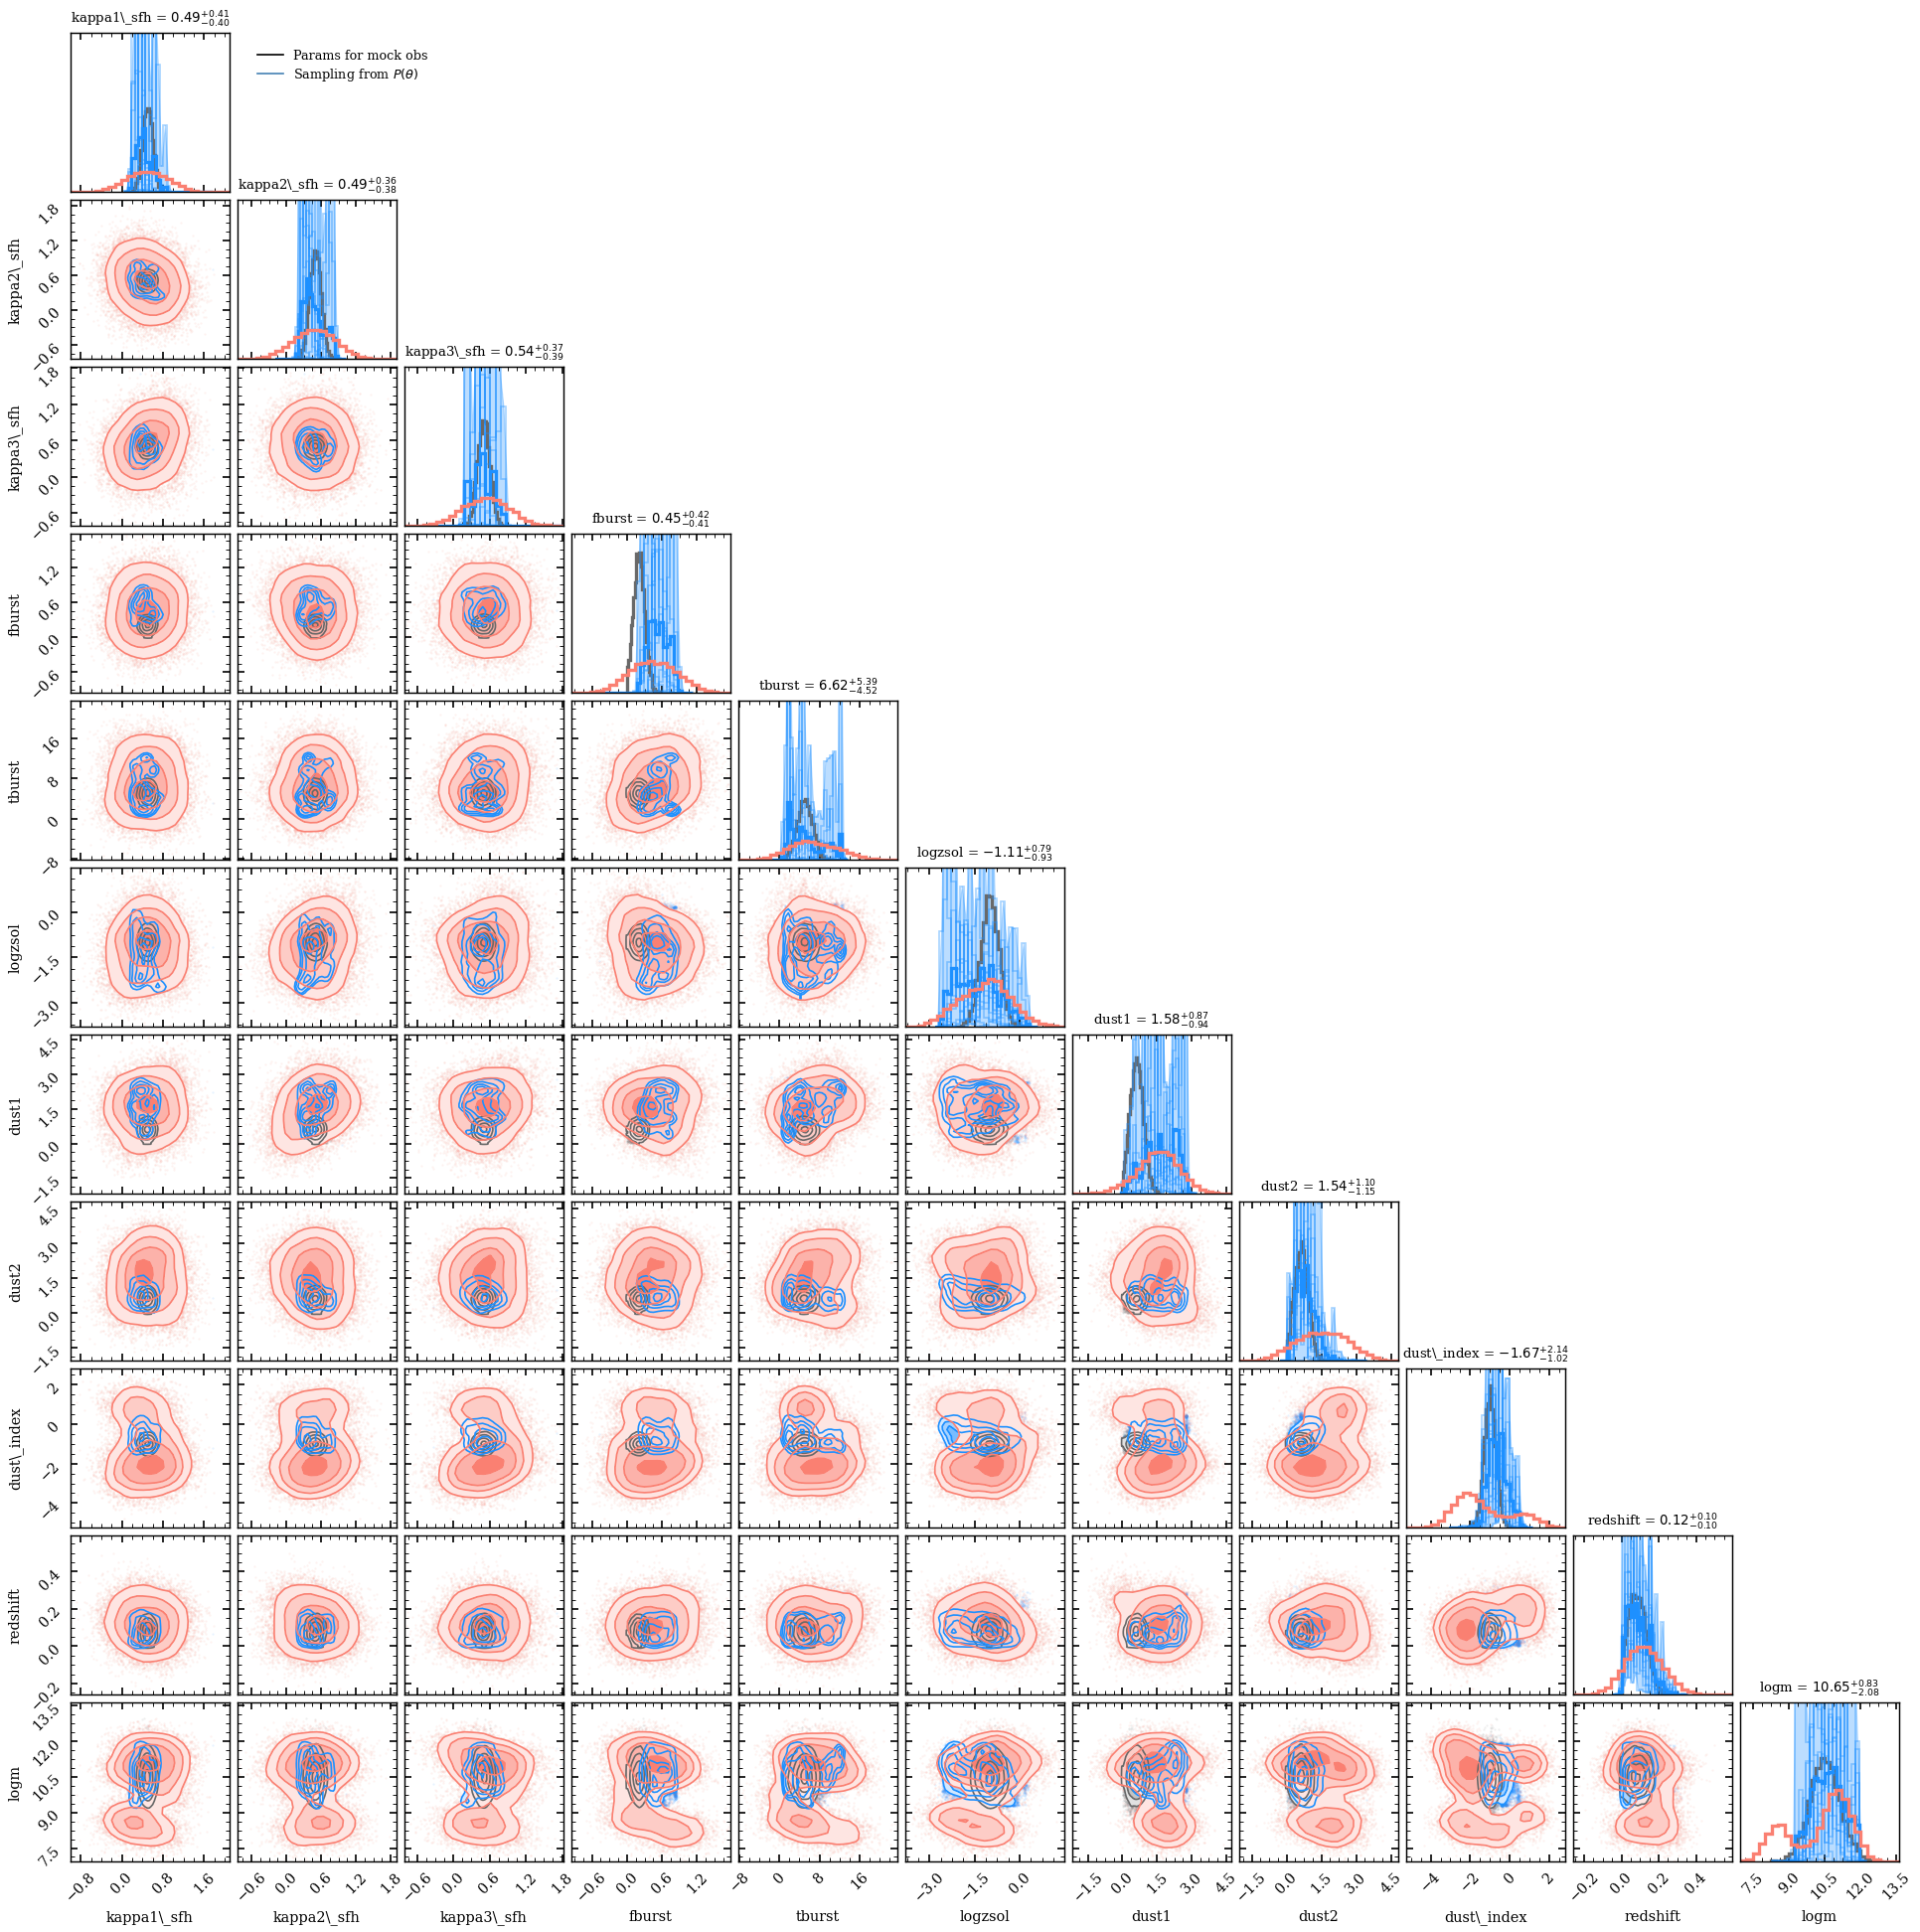

In [26]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Params for mock obs')
b_line = mlines.Line2D([], [], color='steelblue', label=r'Sampling from $P(\theta)$')

labels = [key.replace('_', '\_') for key in speculator.params_name]

figure = corner.corner(Y_truth.cpu().detach().numpy(), 
                       color='dimgray', labels=labels, bins=25,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=1, fill_contours=True,
                       show_titles=True, title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

nf_plot = corner.corner(_samples_unt, 
                  fig=figure, labels=labels, bins=25,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=1, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True})

_ = corner.corner(_init_sample, 
                   fig=figure, color='salmon', alpha=0.1, labels=labels, bins=25,
                   #quantiles=[0.16, 0.5, 0.84], 
                   smooth=0.8, fill_contours=True,
                   show_titles=True, 
                   hist_kwargs={'density': True, 'lw': 0.5}, 
                   title_kwargs={"fontsize": 12},
                   plot_datapoints=True)

ax = nf_plot.get_axes()[1]
ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

In [27]:
# samples.swapaxes(0, 1).reshape(6, -1).T.shape